# Datas 

- Source for airports locations: https://openflights.org/data.html (file airlines.dat)
- Source for american airlines and flight scedules: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236


In [1]:
from visuMultiStream import *
print("1")
from intervals import *
print("2")
from structure import *
print("3")
from elemMSGraph import *
print("4")
from multiLayers import *
print("5")
from sortedcollection import *
print("6")
from matrices import *
print("7")
from random import *
print("8")
import seaborn as sns
print("9")

from tulip import tlp
print("10")
import scipy.linalg
print("finished")

sorted collection imported
1
2
3
4
5
6
7
8
9
10
finished


Echelle de temps : 1 mois

In [12]:
t0=0
tend=24*60*31

print(tend)

interval=Interval(t0,tend)

44640


In [3]:
def convertToMinutes(day,hour,minutes):
    return((day-1)*24*60+hour*60+minutes)



def readAirports(airportl):
    dicoAir={}
    f=open("planes/airports.dat","r",encoding="utf8")
    #print(f)
    lste=[]
    for line in f:
        line=line.replace("\"",'')
        tab=line.split(",")
        ida=tab[4]
        namea=tab[1]
        country=tab[3]
        #print(ida)
        if (ida in dicoAir)==False and (ida in airportl):
            lat=tab[6]
            long=tab[7]
            dicoAir[ida]=[namea,lat,long]
            lste.append(NodeT(ida,IntervalList([interval])))
    return(dicoAir,lste)
    

def readLinks():
    f=open("planes/linksmonth.csv",'r')
    n=0
    em=LinkList([])
    careersl=[]
    airportl=[]
    airportPerLay={}
    for line in f:
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            date=int(tab[0].split("-")[2])
            career=tab[1]
            origin=tab[2]
            dest=tab[3]
            dept=int(tab[4][0]+tab[4][1])*60+int(tab[4][2]+tab[4][3])
            if len(tab[5])>0:
                arrival=int(tab[6][0]+tab[6][1])*60+int(tab[6][2]+tab[6][3])
                inter=Interval((date-1)*24*60+dept,(date-1)*24*60+arrival)
                if arrival<=dept:
                    inter=Interval((date-1)*24*60+dept,(date)*24*60+arrival)
                if not (career in careersl):
                    careersl.append(career)
                if not (origin in airportl):
                    airportl.append(origin)
                if not (dest in airportl):
                    airportl.append(dest)
                if (career in airportPerLay.keys())==False:
                    airportPerLay[career]=[]
                if not origin in airportPerLay[career]:
                    airportPerLay[career].append(origin)
                if not dest in airportPerLay[career]:
                    airportPerLay[career].append(dest)
                em.addLink(Link(IntervalList([inter]),NodeT(origin,IntervalList([interval])),[career],NodeT(dest,IntervalList([interval])),[career],directed=0),cond=0)
        n=n+1
    return(em,sorted(careersl),sorted(airportl),airportPerLay)

    
def readCarriers(carL):
    f=open("planes/L_UNIQUE_CARRIERS.csv","r")
    n=0
    liste=[]
    dicoCarreer={}
    for line in f :
        if n>0:
            line=line.replace("\"",'')
            tab=line.split(",")
            tab[-1]=tab[-1].rstrip("\n")
            code=tab[0]
            name=tab[1]
            if (code in liste) == False and (code in carL)==True :
                liste.append(code)
                dicoCarreer[code]=name
        n=n+1
    comp=Aspect("carrier",liste)
    return(comp,dicoCarreer)

# Principle :

In the datasets, they are to many airports and carriers (not american and unused). So we begin to read the links to know which airports and carriers are used and we then read their datasets to collect their detailed informations (stored into dictionnaries)

In [4]:
em,carL,airportl,airportperlay=readLinks()

dicoAir,nodes=readAirports(airportl)

laystr=LayerStruct([Aspect("compagnies",carL)])
listLay=[]

carriers,dicoCarreer =readCarriers(carL)

for l in carriers.giveElemLayer():
    nl=NodeTList([])
    for no in airportperlay[l]:
        nl.addNodeT(NodeT(no,IntervalList([interval])))
    listLay.append(Layer(laystr,[l],interval,nl))

layers=LayerList(listLay)

m=MultiStream(interval,laystr,layers,em)          

multi=m.extractML()

extracting...
layer ['9E']
layer ['AA']
layer ['AS']
layer ['B6']
layer ['DL']
layer ['EV']
layer ['F9']
layer ['G4']
layer ['HA']
layer ['MQ']
layer ['NK']
layer ['OH']
layer ['OO']
layer ['UA']
layer ['WN']
layer ['YV']
layer ['YX']


In [11]:
m2=m.cut(Interval(0,24*60))
m2=m2.extractLayers([["G4"]])
m2.drawMS("avions.fig")

## Build the tulip file

The differents layers corresponding to the different carriers are drawn in different colors. We build different subgraphs corresponding to each company.

This is very useful for vizualisation (download tulip http://tulip.labri.fr/TulipDrupal/ ) to open the graph (double click on the graph on the bottom left and chose the "geographic view"

In [5]:
def makeGraph(m,airportl,carL,dicoAir,airportperlay):
    graph=tlp.newGraph()
    latitude=graph.getDoubleProperty("latitude")
    longitude=graph.getDoubleProperty("longitude")
    name = graph.getStringProperty("nameCity")
    code = graph.getStringProperty("code")
    couche = graph.getStringVectorProperty("compagnie")
    color = graph.getColorProperty("viewColor")
    k=len(carL)
    colList=[(randint(0,255),randint(0,255),randint(0,255)) for i in range(k)]
    for n in range(len(airportl)):
        graph.addNode()
        no=graph.nodes()[n]
        code[no]=airportl[n]
        listeAttributs=dicoAir[airportl[n]]
        name[no]=listeAttributs[0]
        latitude[no]=float(listeAttributs[1])
        longitude[no]=float(listeAttributs[2])
    n=0
    for lay in m.giveLayers().giveLayers():
        car=lay.giveLayerLabel()[0]
        sub=graph.addSubGraph(car)
        nliste=airportperlay[car]
        for node1 in nliste :
            no=graph.nodes()[airportl.index(node1)]
            sub.addNode(no)
        #print(car,len(sub.nodes()))
    for e in m.giveLinks().giveListOfLinks():
        n1=graph.nodes()[airportl.index(e.giveNodes()[0].giveNode())]
        n2=graph.nodes()[airportl.index(e.giveNodes()[1].giveNode())]
        graph.addEdge(n1,n2)
        ed=graph.edges()[n]
        n=n+1
        couche[ed]=e.giveLabel()[2]
        color[ed]=colList[carL.index(e.giveLabel()[2][0])]
        sub=graph.subGraphs()[carL.index(e.giveLabel()[2][0])]
        car=e.giveLabel()[2][0]
        codenode=e.giveNodes()[0].giveNode()
        n1=sub.nodes()[airportperlay[car].index(codenode)]
        n2=sub.nodes()[airportperlay[e.giveLabel()[2][0]].index(e.giveNodes()[1].giveNode())]
        sub.addEdge(ed)
    tlp.saveGraph(graph,"grapheplanes.tp")
    return(graph)

graph=makeGraph(m,airportl,carL,dicoAir,airportperlay)

We can then use the library "tulip" to compute classical measures: 

- page ranking: 

In [6]:
pagerank=graph.getDoubleProperty("pageRank")
params = tlp.getDefaultPluginParameters('Page Rank', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Page Rank', pagerank, params)
pr=[]
for n in graph.getNodes():
    pr.append(pagerank[n])

- betweenness centrality:

In [7]:
betweenness=graph.getDoubleProperty("betweeness")
params = tlp.getDefaultPluginParameters('Betweenness Centrality', graph)
params["directed"]=True

success = graph.applyDoubleAlgorithm('Betweenness Centrality', betweenness, params)
bt=[]
for n in graph.getNodes():
    bt.append(betweenness[n]) 

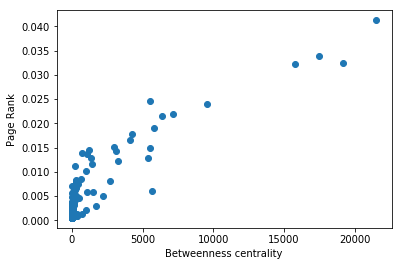

In [8]:
axes = plt.gca()
plt.plot(bt,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('Betweenness centrality')
plt.savefig("prVSbc.pdf")
plt.show()


# Intrication

We compute the Burt's matrix which is:

$\begin{pmatrix}
P(1) & P(1|2) & P(1|3) & \dots & P(1|n)\\
P(2|1) & P(2) & P(2|3) & \dots & P(2|n)\\
\vdots & \vdots & \ddots\\
\dots & \dots & \dots & \dots & P(n)
\end{pmatrix}$

$P(i)$ is the probability, taking a flight, that it exists in the compagny $C_i$.

$P(i|j)$ is the probability, taking a flight in $c_j$, that $c_i$ has the same flight.

In [13]:
matintric=multi.computeIntricationMatrixBurt()

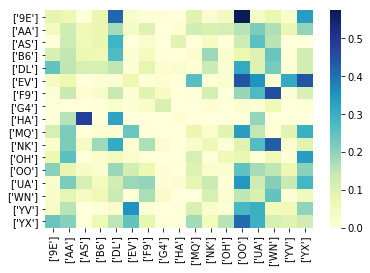

In [50]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matintric),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("intricplanes.pdf")
plt.show()


We compute its maximal left eigenvalue and the eigenvector associated. If the matrix isn't reductible (if we have all the nodes in the same connex component), this eigenvalue is unique and the eigenvector has all its coefficients of the same sign.

In [51]:
valp,vectp=valeurPropreMax(np.transpose(matintric),1000)

We draw the eigenvector ordered:

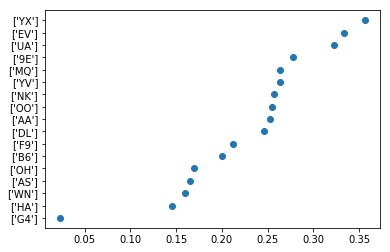

In [12]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectp[lablist.index(lab)])
vectpo,labo=l.listsSorted()

plt.plot(labo,vectpo,'o')
plt.savefig("intricscoresplanes.pdf")
plt.show()

 # Covariance

In [67]:
matcov=multi.computeCovariance()

N= 2777


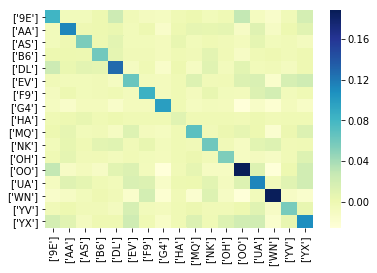

In [68]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matcov),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()

In [112]:
valpcov,vectpcov=valeurPropreMax(np.transpose(matcov),1000)
print(valpcov)

0.24319570569859572


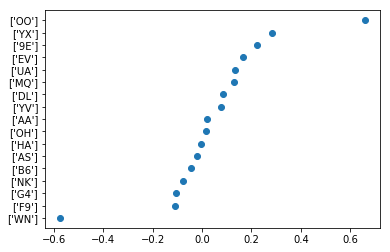

0.24319570569859572


In [70]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpcov[lablist.index(lab)])
vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
plt.savefig("covscoresplanes.pdf")
plt.show()

print(valpcov)

## Test: covariance valeur propre minimale

In [114]:
vp,vectpro=np.linalg.eig(matcov)

taux=[matintric[i][i] for i in range(len(matcov))]

print(vp,vectpro)

for i in range(len(vectpro)):
    esp=0
    for j in range(len(vectpro[i])):
        esp=esp+vectpro[i][j]*taux[j]
    print("esp",esp, "lambda", vp[i])
    
esp_glob=0
for i in range(len(taux)):
    esp_glob=esp_glob+taux[i]
print("esperance globale=",esp_glob)
print("variance globale = ", )

[0.24319571 0.1866247  0.15512387 0.14576064 0.0103496  0.11018582
 0.10335729 0.08490164 0.03376017 0.0381942  0.07666925 0.04733486
 0.05253715 0.06799162 0.06005574 0.06082589 0.06404466] [[-0.22073867  0.11121548 -0.21346488  0.18025907 -0.01415065  0.25559651
   0.20349737  0.16868788 -0.2242464  -0.18197577 -0.02151906  0.12714342
   0.07560632  0.21496307 -0.65654094 -0.37363192  0.05334766]
 [-0.02197596 -0.10642887  0.37821769  0.40643746 -0.00298469  0.18383982
  -0.67375776  0.23898574 -0.05995859 -0.08106763  0.27862009  0.03377809
  -0.13328082 -0.10498746 -0.12669186  0.03184258 -0.0170939 ]
 [ 0.01878084 -0.02488859 -0.01239686  0.11069212  0.08170232 -0.19138779
  -0.03898154 -0.23825417 -0.43435268  0.05735193 -0.00759842  0.52011562
  -0.37057729  0.23870631  0.22119348 -0.07755114  0.41623766]
 [ 0.04324019 -0.01192086 -0.02191426  0.1602092  -0.02870532  0.01684608
   0.05210875 -0.14725608 -0.23986773  0.05381958 -0.07734905 -0.38229699
  -0.47982582  0.44230166 -0

## Tests precision

In [73]:
matprec=np.linalg.inv(matcov)
#for i in range(len(matprec)):
#    matprec[i][i]=0

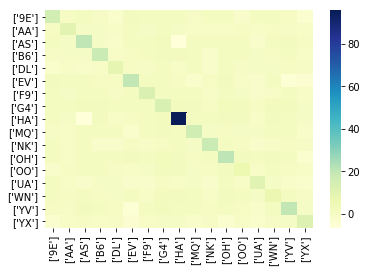

In [74]:
lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matprec),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()

In [113]:
valpprec,vectpprec=valeurPropreMax(np.transpose(matprec),1000)
print(1/valpprec)

0.01034959619041909


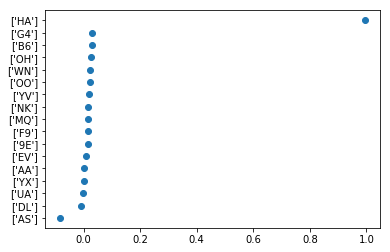

96.62212724064808


In [76]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpprec[lablist.index(lab)])


vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
plt.savefig("precscoresplanes.pdf")
plt.show()

print(valpprec)

## Next VP

[[-8.14812670e+01  9.65999986e-01  1.65367737e+00  1.99294205e-03
  -2.43131150e+00  2.13384579e+00  1.15146760e+00  1.40298318e+00
   1.13825022e+00  8.42079229e-02  1.01714428e+00  1.20518569e+00
  -1.50964027e+00  1.23161327e+00  1.18167083e+00  6.53250207e-01
  -2.77769435e+00]
 [ 9.65999986e-01 -8.70277350e+01  4.77929834e-01  2.41539872e-01
  -2.91756133e-01  1.45801989e+00  1.81616399e-01  1.65767003e+00
   2.07563893e-01 -6.78075359e-01 -5.69091891e-01 -6.03917993e-01
   8.63381856e-01 -8.39597389e-01  8.74604019e-01 -1.21146528e-01
  -8.01434930e-01]
 [ 1.65367737e+00  4.77929834e-01 -7.64106519e+01  4.30273108e-01
  -1.08717932e+00  1.17208281e+00  1.63660122e+00  2.41814076e+00
  -6.61493858e+00  1.25456708e+00  1.20632767e+00  1.68933292e+00
   1.07262819e+00 -1.68288474e+00  1.26163450e+00  1.78005489e+00
   9.40007286e-01]
 [ 1.99294205e-03  2.41539872e-01  4.30273108e-01 -7.90384851e+01
  -5.22960041e-01  6.87986192e-01  1.16224296e+00  2.10485572e+00
   2.11515742e+00  

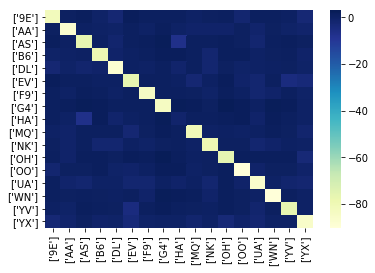

In [52]:
matprec2=matprec-valpprec*np.eye(17)
print(matprec2)

lablist=multi.giveLayersLabels()
sns_plot=sns.heatmap(np.transpose(matprec2),cmap="YlGnBu",xticklabels=lablist,yticklabels=lablist)
fig = sns_plot.get_figure()
fig.savefig("matcov.pdf")
plt.show()


In [23]:
valpp2,vectpp2=valeurPropreMax(np.transpose(matprec2),1000)

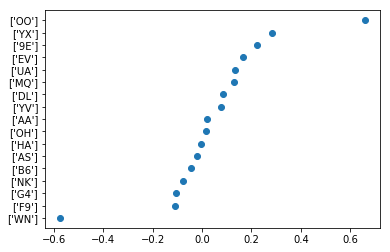

189.13233976993962


In [24]:
l=SortedCollection(iterable=lablist,key = lambda lab: vectpp2[lablist.index(lab)])


vectcova,labo2=l.listsSorted()

plt.plot(labo2,vectcova,'o')
#plt.savefig("precscoresplanes.pdf")
plt.show()

print(valpp2+valpprec)

# Random walks

A step: to go on, a passenger will chose among all the possibles links he can take. Each link corresponds to a company and a destination.

For instance, from `['Montgomery Regional (Dannelly Field) Airport', '32.30059814', '-86.39399719']`
we can reach with the same probability:
```
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with Endeavor Air Inc.
['Hartsfield Jackson Atlanta International Airport', '33.6367', '-84.428101'] with SkyWest Airlines Inc.
['Ronald Reagan Washington National Airport', '38.8521', '-77.037697'] with PSA Airlines Inc.
['Dallas Fort Worth International Airport', '32.896801', '-97.038002'] with Envoy Air
```


In [25]:
def step(pos0,airportl,m,t,prints=False):
    if prints==True:
        print(dicoAir[pos0])
    bloque=False
    possibleDest={}
    listDest=[]
    car="none"
    for link in m.giveLinks().giveListOfLinks():
        if link.giveNodes()[0].giveNode()==pos0:
            dest=link.giveNodes()[1].giveNode()
            if not dest in listDest:
                listDest.append(dest)
                possibleDest[dest]=[]
            possibleDest[dest].append(link)
            #print(link.giveLabel())
            #print(dicoAir[(link.giveLabel()[1])],dicoCarreer[link.giveLabel()[2][0]])
    if len(listDest)==0:
        bloque=True
        pos1=pos0
        print("no neighbours")
        t1=t
    else:
        #print("----------------------------")
        li=randint(0,len(listDest)-1)
        operListe=possibleDest[listDest[li]]
        link0i=randint(0,len(operListe)-1)
        link0=operListe[link0i]
        #link0.printLink()
        #print(link0.giveLabel())
        pos1=link0.giveNodes()[1].giveNode()
        intervalsL=link0.giveIntervals()
        i=0
        car=link0.giveLabel()[2][0]
        while i<len(intervalsL) and intervalsL[i].begining()<t :
            i=i+1
        if i==len(intervalsL):
            bloque=True
            t1=t
            print("timeout")
        else:
            t1=intervalsL[i].end()
    return(pos1,t1,car,bloque)

pos0=airportl[randint(0,len(airportl)-1)]
step(pos0,airportl,m,0)

('MSP', 471, 'OO', False)

From that, we compute the random walk: 

In [26]:
def randomWalk(airportl,m,t,collect="coverage",prints=False,boucles=1):
    pos0=airportl[randint(0,len(airportl)-1)]
    t=0
    bloque=False
    i=0
    b=0
    if collect=="coverage":
        airports=np.array([0 for i in range(len(airportl))])
        compagnies=np.array([0 for i in range(len(carL))])
    if collect=="firstTimeToReach":
        airports=np.array([tend for i in range(len(airportl))])
        compagnies=np.array([tend for i in range(len(carL))])
    while bloque==False and b<boucles:
        if prints==True:
            print(pos0,t)
        pos0,t,car,bloque=step(pos0,airportl,m,t,prints=prints)
        if bloque==True:
            b=b+1
            t=0
            bloque=False
        if collect=="coverage":
            airports[airportl.index(pos0)]=airports[airportl.index(pos0)]+1
            compagnies[carL.index(car)]=compagnies[carL.index(car)]+1
        if collect=="firstTimeToReach":
            if airports[airportl.index(pos0)]==tend:
                airports[airportl.index(pos0)]=t
            if compagnies[carL.index(car)]== tend:
                compagnies[carL.index(car)]=t
        i=i+1
    return([pos0,t,airports,compagnies])

randomWalk(airportl,m,0,prints=True,boucles=10)

TXK 0
['Texarkana Regional Webb Field', '33.45370101928711', '-93.99099731445312']
DFW 465
['Dallas Fort Worth International Airport', '32.896801', '-97.038002']
LEX 951
['Blue Grass Airport', '38.0364990234375', '-84.60590362548828']
IAH 1975
['George Bush Intercontinental Houston Airport', '29.984399795532227', '-95.34140014648438']
BNA 2194
['Nashville International Airport', '36.1245002746582', '-86.6781997680664']
MSY 2390
['Louis Armstrong New Orleans International Airport', '29.99340057373047', '-90.25800323486328']
IAH 6697
['George Bush Intercontinental Houston Airport', '29.984399795532227', '-95.34140014648438']
STL 7172
['St Louis Lambert International Airport', '38.748697', '-90.370003']
PBI 8035
['Palm Beach International Airport', '26.68320083618164', '-80.09559631347656']
timeout
MSP 0
['Minneapolis-St Paul International/Wold-Chamberlain Airport', '44.882', '-93.221802']
AUS 1255
['Austin Bergstrom International Airport', '30.194499969482422', '-97.6698989868164']
ORD 6

DFW 14040
['Dallas Fort Worth International Airport', '32.896801', '-97.038002']
RAP 14177
['Rapid City Regional Airport', '44.0452995300293', '-103.05699920654297']
timeout
ORD 0
["Chicago O'Hare International Airport", '41.9786', '-87.9048']
MIA 673
['Miami International Airport', '25.79319953918457', '-80.29060363769531']
MSY 1266
['Louis Armstrong New Orleans International Airport', '29.99340057373047', '-90.25800323486328']
SEA 2735
['Seattle Tacoma International Airport', '47.449001', '-122.308998']
SFO 3455
['San Francisco International Airport', '37.61899948120117', '-122.375']
DEN 3675
['Denver International Airport', '39.861698150635', '-104.672996521']
OMA 9721
['Eppley Airfield', '41.3032', '-95.894096']
EWR 9962
['Newark Liberty International Airport', '40.692501068115234', '-74.168701171875']
MYR 12427
['Myrtle Beach International Airport', '33.6796989441', '-78.9282989502']
BWI 16721
['Baltimore/Washington International Thurgood Marshall Airport', '39.1754', '-76.668297'

['CLT',
 0,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        2, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 4,
        1, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 4, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 6, 0, 1, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 7, 2, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 7, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 

We compute then a great amount of random walks, collecting several informations:

- the coverage

In [42]:
covAirports=np.array([0 for i in range(len(airportl))])
covCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(10):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    covAirports=np.add(covAirports,airports)
    covCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout


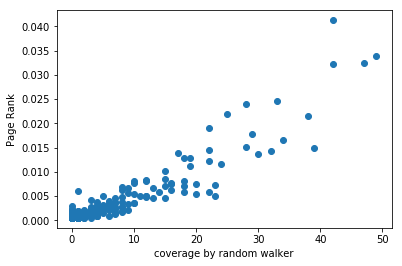

In [43]:
axes = plt.gca()
plt.plot(covAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('coverage by random walker')
plt.savefig("prVSrw.pdf")
plt.show()

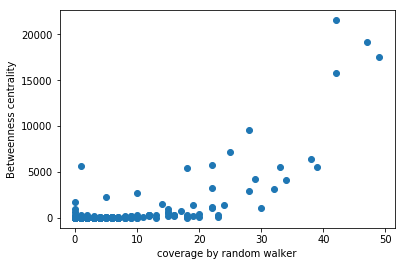

In [44]:
axes = plt.gca()
plt.plot(covAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('coverage by random walker')
plt.savefig('bcVScovrw.pdf')
plt.show()

[ 58 117  41  59 121  49  76 152  13  69  33  56 239 109 296  61  68]
[0.27801714 0.25277487 0.16536946 0.19956213 0.24586113 0.33334731
 0.21209387 0.02362059 0.14503349 0.26303856 0.25672139 0.1693862
 0.25422656 0.32186742 0.16000328 0.26291929 0.35602027]


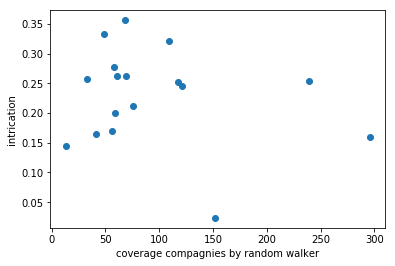

In [53]:
print(covCompagnies)
print(vectp)
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
plt.show()


- the first time to reach

In [54]:
ftrAirports=np.array([0 for i in range(len(airportl))])
ftrCompagnies=np.array([0 for i in range(len(carL))])
airports=np.array([0 for i in (airportl)])
t=0
for i in range(10):
    print("randomwalk n", i)
    vect=randomWalk(airportl,m,t,collect="firstTimeToReach",boucles=10)
    airports=vect[2]
    compagnies=vect[3]
    ftrAirports=np.add(covAirports,airports)
    ftrCompagnies=np.add(covCompagnies,compagnies)

randomwalk n 0
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 1
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 2
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 3
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 4
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 5
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 6
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 7
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 8
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
randomwalk n 9
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout


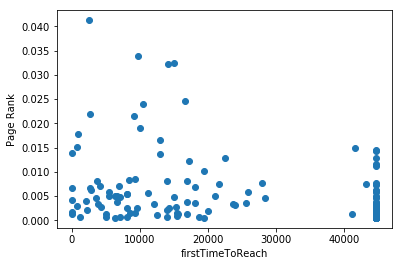

In [32]:
axes = plt.gca()
plt.plot(ftrAirports,pr,'o')
axes.set_ylabel('Page Rank')
axes.set_xlabel('firstTimeToReach')
plt.show()

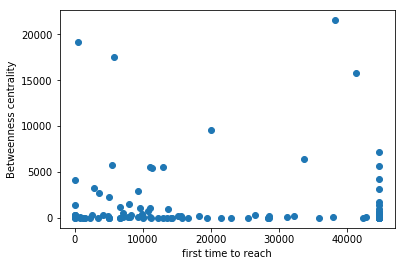

In [55]:
axes = plt.gca()
plt.plot(ftrAirports,bt,'o')
axes.set_ylabel('Betweenness centrality')
axes.set_xlabel('first time to reach')
plt.show()

In [56]:
nnodes=[121,102,70,68,145,101,90,120,18,134,43,95,239,108,85,103,87]
nlinks=[488,721,326,362,834,368,522,614,62,419,366,325,1358,715,1378,335,661]

['9E', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'UA', 'WN', 'YV', 'YX']


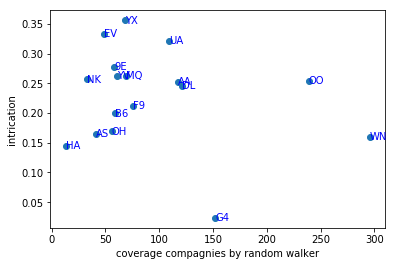

In [57]:
axes=plt.gca()
plt.plot(covCompagnies,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(carL)
ni=0
for i in carL:
    text = axes.text(covCompagnies[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()


[0.4793388429752066, 1.1470588235294117, 0.5857142857142857, 0.8676470588235294, 0.8344827586206897, 0.48514851485148514, 0.8444444444444444, 1.2666666666666666, 0.7222222222222222, 0.5149253731343284, 0.7674418604651163, 0.5894736842105263, 1.0, 1.0092592592592593, 3.4823529411764707, 0.5922330097087378, 0.7816091954022989]


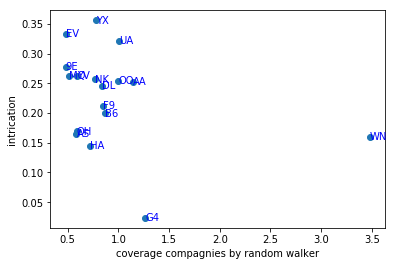

In [58]:
cov2=[covCompagnies[i]/nnodes[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov2,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker')
print(cov2)
ni=0
for i in carL:
    text = axes.text(cov2[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

[-0.11885245901639344, -0.1622746185852982, -0.12576687116564417, -0.16298342541436464, -0.145083932853717, -0.1331521739130435, -0.14559386973180077, -0.247557003257329, -0.20967741935483872, -0.16467780429594273, -0.09016393442622951, -0.1723076923076923, -0.17599410898379972, -0.15244755244755245, -0.21480406386066764, -0.18208955223880596, -0.10287443267776097]


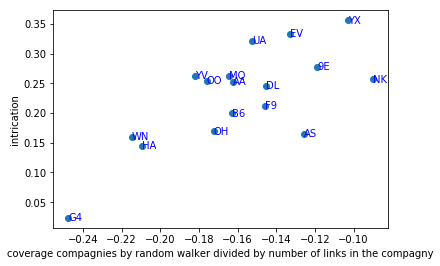

In [84]:
cov3=[-covCompagnies[i]/nlinks[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('coverage compagnies by random walker divided by number of links in the compagny')
print(cov3)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

[0.11885245901639344, 0.1622746185852982, 0.12576687116564417, 0.16298342541436464, 0.145083932853717, 0.1331521739130435, 0.14559386973180077, 0.247557003257329, 0.20967741935483872, 0.16467780429594273, 0.09016393442622951, 0.1723076923076923, 0.17599410898379972, 0.15244755244755245, 0.21480406386066764, 0.18208955223880596, 0.10287443267776097]


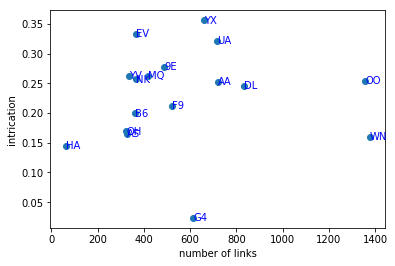

In [60]:
nlinks2=[nlinks[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(nlinks2,vectp,'o')
axes.set_ylabel('intrication')
axes.set_xlabel('number of links')
print(cov3)
ni=0
for i in carL:
    text = axes.text(nlinks2[ni],vectp[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

## Covariance

[ 0.22073867  0.02197596 -0.01878084 -0.04324019  0.08617365  0.16609728
 -0.10736238 -0.10571059 -0.00288777  0.13080882 -0.07876284  0.01608087
  0.65894791  0.13491643 -0.57296667  0.07669357  0.28405015]


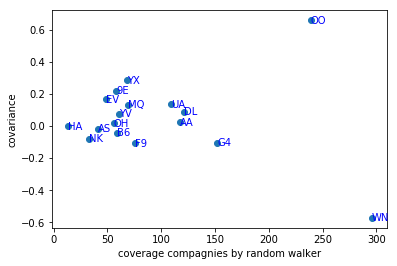

In [81]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectpcov,'o')
axes.set_ylabel('covariance')
axes.set_xlabel('coverage compagnies by random walker')
print(vectpcov)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectpcov[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()

## Precision

[58, 117, 41, 59, 121, 49, 76, 152, 13, 69, 33, 56, 239, 109, 296, 61, 68]


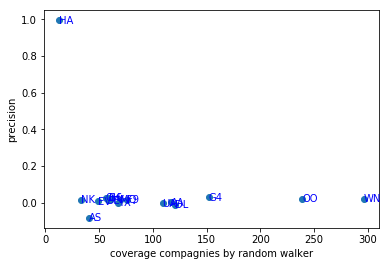

In [79]:
cov3=[covCompagnies[i] for i in range(len(carL))]
axes=plt.gca()
plt.plot(cov3,vectpprec,'o')
axes.set_ylabel('precision')
axes.set_xlabel('coverage compagnies by random walker')
print(cov3)
ni=0
for i in carL:
    text = axes.text(cov3[ni],vectpprec[ni],i,ha="left", va="center", color="b")
    ni=ni+1
plt.show()